<a href="https://colab.research.google.com/github/premdev1234/premdev1234/blob/main/Prem_Dev_(B22BB047)_Lab_3_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Try2

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report

In [12]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype("float32") / 255.
x_test  = x_test.astype("float32") / 255.

In [13]:
# Convert class vectors to one-hot encoded labels
num_classes = 10
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat  = keras.utils.to_categorical(y_test, num_classes)

print("Training samples:", x_train.shape[0])
print("Test samples:", x_test.shape[0])

Training samples: 50000
Test samples: 10000


In [14]:
## 2. Model Architectures
def dense_block_sep(x, num_layers, growth_rate):
    """
    Dense block that uses SeparableConv2D (i.e. depth-wise separable convolution).
    """
    for i in range(num_layers):
        bn = layers.BatchNormalization()(x)
        act = layers.Activation('relu')(bn)
        conv = layers.SeparableConv2D(growth_rate, kernel_size=3, padding='same',
                                      depth_multiplier=1)(act)
        x = layers.Concatenate()([x, conv])
    return x

def dense_block_trad(x, num_layers, growth_rate):
    """
    Dense block that uses traditional Conv2D.
    """
    for i in range(num_layers):
        bn = layers.BatchNormalization()(x)
        act = layers.Activation('relu')(bn)
        conv = layers.Conv2D(growth_rate, kernel_size=3, padding='same')(act)
        x = layers.Concatenate()([x, conv])
    return x

def transition_layer(x, reduction=0.5):
    """
    Transition layer: reduce number of feature maps and spatial dimensions.
    """
    filters = int(K.int_shape(x)[-1] * reduction)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size=1, padding='same')(x)
    x = layers.AveragePooling2D(pool_size=2, strides=2)(x)
    return x

In [15]:
def build_model(use_separable=True, input_shape=(32, 32, 3), num_classes=10,
                initial_filters=64, num_dense_blocks=4, num_layers_per_block=4, growth_rate=32):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(initial_filters, kernel_size=3, padding='same')(inputs)

    for i in range(num_dense_blocks):
        if use_separable:
            x = dense_block_sep(x, num_layers=num_layers_per_block, growth_rate=growth_rate)
        else:
            x = dense_block_trad(x, num_layers=num_layers_per_block, growth_rate=growth_rate)
        if i != num_dense_blocks - 1:
            x = transition_layer(x, reduction=0.5)

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


model_sep = build_model(use_separable=True)
model_trad = build_model(use_separable=False)

print("=== Model with Depth-wise Separable Convolutions ===")
model_sep.summary()
print("\n=== Model with Traditional Convolutions ===")
model_trad.summary()

=== Model with Depth-wise Separable Convolutions ===


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 32, 32, 64)     │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_35    │ (None, 32, 32, 64)     │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 32, 32, 32)     │          2,656 │ activation[0][0]       │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_16            │ (None, 32, 32, 96)     │              0 │ conv2d_20[0][0],       │
│ (Concatenate)             │                        │                │ separable_conv2d[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 32, 32, 96)     │            384 │ concatenate_16[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 96)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 32, 32, 32)     │          3,968 │ activation_1[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_17            │ (None, 32, 32, 128)    │              0 │ concatenate_16[0][0],  │
│ (Concatenate)             │                        │                │ separable_conv2d_1[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 32, 32, 128)    │            512 │ concatenate_17[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 32, 32, 32)     │          5,280 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_18            │ (None, 32, 32, 160)    │              0 │ concatenate_17[0][0],  │
│ (Concatenate)             │                        │                │ separable_conv2d_2[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 186,178 (727.26 KB)

 Trainable params: 179,698 (701.95 KB)

 Non-trainable params: 6,480 (25.31 KB)


=== Model with Traditional Convolutions ===


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 32, 32, 64)     │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_55    │ (None, 32, 32, 64)     │            256 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 32, 32, 64)     │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 32, 32, 32)     │         18,464 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_32            │ (None, 32, 32, 96)     │              0 │ conv2d_24[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_56    │ (None, 32, 32, 96)     │            384 │ concatenate_32[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_21             │ (None, 32, 32, 96)     │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 32, 32, 32)     │         27,680 │ activation_21[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_33            │ (None, 32, 32, 128)    │              0 │ concatenate_32[0][0],  │
│ (Concatenate)             │                        │                │ conv2d_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_57    │ (None, 32, 32, 128)    │            512 │ concatenate_33[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_22             │ (None, 32, 32, 128)    │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 32, 32, 32)     │         36,896 │ activation_22[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_34            │ (None, 32, 32, 160)    │              0 │ concatenate_33[0][0],  │
│ (Concatenate)             │                        │                │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5

 Total params: 763,170 (2.91 MB)

 Trainable params: 756,690 (2.89 MB)

 Non-trainable params: 6,480 (25.31 KB)

In [16]:
model_sep.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
model_trad.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [17]:
batch_size = 64
epochs = 100

print("Training model with separable convolutions...")
start_time_sep = time.time()
history_sep = model_sep.fit(x_train, y_train_cat,
                            validation_split=0.1,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=2)
training_time_sep = time.time() - start_time_sep
print(f"Training time (separable model): {training_time_sep:.6f} seconds")

Training model with separable convolutions...
Epoch 1/100
704/704 - 95s - 135ms/step - accuracy: 0.5477 - loss: 1.2484 - val_accuracy: 0.5542 - val_loss: 1.2688
Epoch 2/100
704/704 - 23s - 32ms/step - accuracy: 0.7064 - loss: 0.8245 - val_accuracy: 0.5380 - val_loss: 1.6346
Epoch 3/100
704/704 - 23s - 33ms/step - accuracy: 0.7750 - loss: 0.6442 - val_accuracy: 0.6002 - val_loss: 1.3365
Epoch 4/100
704/704 - 40s - 57ms/step - accuracy: 0.8148 - loss: 0.5326 - val_accuracy: 0.6808 - val_loss: 1.0202
Epoch 5/100
704/704 - 23s - 32ms/step - accuracy: 0.8448 - loss: 0.4526 - val_accuracy: 0.7278 - val_loss: 0.8734
Epoch 6/100
704/704 - 42s - 59ms/step - accuracy: 0.8654 - loss: 0.3895 - val_accuracy: 0.7202 - val_loss: 0.9502
Epoch 7/100
704/704 - 40s - 57ms/step - accuracy: 0.8852 - loss: 0.3317 - val_accuracy: 0.7312 - val_loss: 0.9554
Epoch 8/100
704/704 - 23s - 33ms/step - accuracy: 0.9007 - loss: 0.2856 - val_accuracy: 0.7424 - val_loss: 0.9519
Epoch 9/100
704/704 - 41s - 58ms/step - a

In [18]:
print("Training model with traditional convolutions...")
start_time_trad = time.time()
history_trad = model_trad.fit(x_train, y_train_cat,
                              validation_split=0.1,
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=2)
training_time_trad = time.time() - start_time_trad
print(f"Training time (traditional model): {training_time_trad:.6f} seconds")

Training model with traditional convolutions...
Epoch 1/100
704/704 - 76s - 108ms/step - accuracy: 0.5440 - loss: 1.2580 - val_accuracy: 0.5850 - val_loss: 1.1681
Epoch 2/100
704/704 - 45s - 64ms/step - accuracy: 0.7106 - loss: 0.8173 - val_accuracy: 0.6598 - val_loss: 0.9956
Epoch 3/100
704/704 - 41s - 59ms/step - accuracy: 0.7824 - loss: 0.6246 - val_accuracy: 0.6458 - val_loss: 1.0878
Epoch 4/100
704/704 - 40s - 57ms/step - accuracy: 0.8261 - loss: 0.5054 - val_accuracy: 0.6580 - val_loss: 1.1494
Epoch 5/100
704/704 - 41s - 58ms/step - accuracy: 0.8552 - loss: 0.4199 - val_accuracy: 0.6638 - val_loss: 1.1327
Epoch 6/100
704/704 - 41s - 59ms/step - accuracy: 0.8823 - loss: 0.3462 - val_accuracy: 0.7310 - val_loss: 0.8889
Epoch 7/100
704/704 - 26s - 37ms/step - accuracy: 0.9019 - loss: 0.2814 - val_accuracy: 0.7016 - val_loss: 1.1704
Epoch 8/100
704/704 - 41s - 58ms/step - accuracy: 0.9193 - loss: 0.2343 - val_accuracy: 0.6842 - val_loss: 1.4192
Epoch 9/100
704/704 - 26s - 38ms/step -

In [19]:
def evaluate_model(model, x_test, y_test_cat, y_test_labels):
    loss, accuracy = model.evaluate(x_test, y_test_cat, verbose=0)
    print(f"Test Loss: {loss:.4f} - Test Accuracy: {accuracy:.4f}")

    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_test_labels, y_pred, digits=4))

    return accuracy

print("Evaluation for model with separable convolutions:")
acc_sep = evaluate_model(model_sep, x_test, y_test_cat, y_test.flatten())

print("Evaluation for model with traditional convolutions:")
acc_trad = evaluate_model(model_trad, x_test, y_test_cat, y_test.flatten())

Evaluation for model with separable convolutions:
Test Loss: 1.2213 - Test Accuracy: 0.8289
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.8337    0.8720    0.8524      1000
           1     0.9094    0.9240    0.9167      1000
           2     0.8168    0.7180    0.7642      1000
           3     0.7946    0.5840    0.6732      1000
           4     0.8193    0.7980    0.8085      1000
           5     0.7145    0.8160    0.7619      1000
           6     0.9059    0.8280    0.8652      1000
           7     0.7290    0.9440    0.8227      1000
           8     0.8792    0.9320    0.9049      1000
           9     0.9297    0.8730    0.9005      1000

    accuracy                         0.8289     10000
   macro avg     0.8332    0.8289    0.8270     10000
weighted avg     0.8332    0.8289    0.8270     10000

Evaluation for model with traditional convolutions:
Test Loss: 0.8824 - Test Accura

In [20]:
def plot_training_curves(history, title="Training Curves"):
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title + " - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title + " - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

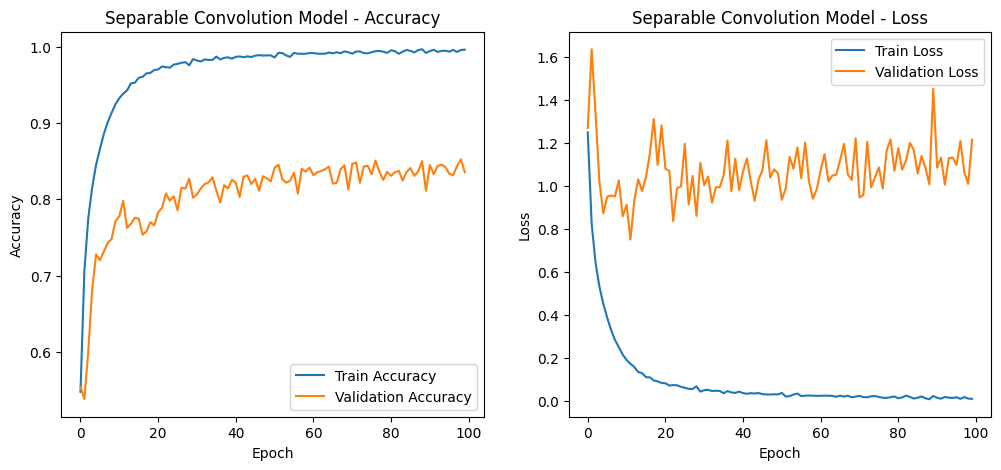

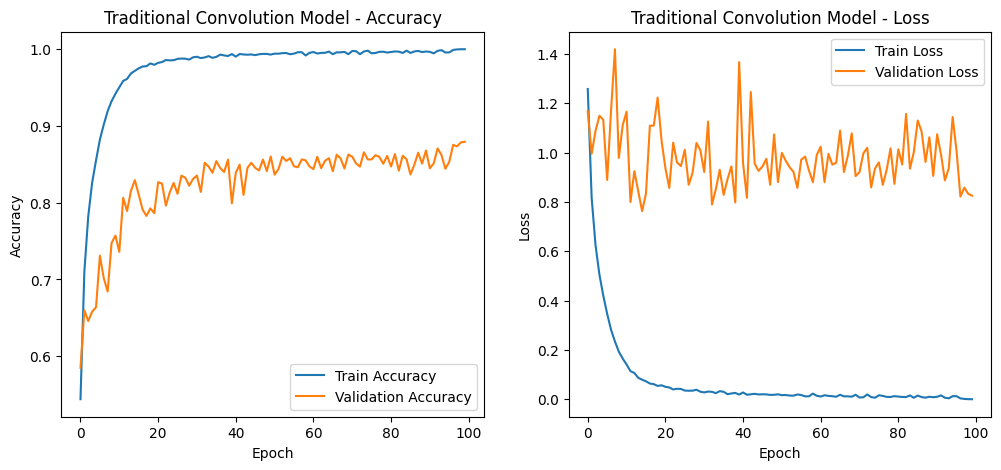

In [21]:
plot_training_curves(history_sep, "Separable Convolution Model")
plot_training_curves(history_trad, "Traditional Convolution Model")